In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [1]:
BASE_DIR = '/workspace/BoneMeta_nnUNet'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels'

In [3]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

False

In [4]:
def get_image_file(filename):
    return np.load(get_img_path(filename))

def get_label_file(filename):
    return np.load(get_label_path(filename))

In [5]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_nnUNet/images 450
/workspace/BoneMeta_nnUNet/1st_pred 419


In [6]:
# 케이스별 DICOM 읽기: case_name, base_dir -> npy
def dcm_to_numpy(case_name, base_dir):
  dicoms = sorted(glob.glob(f'{base_dir}/{case_name}/*'))
  dcm_reader = sitk.ImageSeriesReader()
  dcm_reader.SetFileNames(dicoms)
  img_arr = sitk.GetArrayFromImage(dcm_reader.Execute())
  return img_arr

def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

# npy image windowing 하기
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.copy()
    copied_image[copied_image<lower] = lower
    copied_image[copied_image>upper] = upper
    copied_image = copied_image-lower
    return (copied_image/(upper-lower)*255).round().astype(np.uint8)

# # 2nd version
# def adjust_window(image, window):
#     width = window[0]
#     level = window[1]
#     upper = level+width/2
#     lower = level-width/2
#     copied_image = image.clip(lower, upper)
#     copied_image = copied_image-lower
#     return (copied_image/(upper-lower)*255)

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

In [7]:
#image, label 동시에 그려줌
def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  f = plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
#   plt.show()
  return f

In [8]:
IMG_FILES[:5]

['BH001_20190501_Abdomen_&_pelvis_CT_(3D).npy',
 '000362_20191214_Chest_CT_(contrast).npy',
 'BH010_20161101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy',
 'BH005_20170707_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy',
 '000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy']

In [9]:
LABEL_FILES[:5]

['BH001_20190501_Abdomen_&_pelvis_CT_(3D).npy',
 '000362_20191214_Chest_CT_(contrast).npy',
 'BH010_20161101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy',
 'BH005_20170707_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy',
 '000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy']

In [10]:
def file_test(filename):
    image = get_image_file(filename)
    adj_image = adjust_window(image, (700,200))
    label = get_label_file(filename)
    plot_img_and_label(adj_image, label)

In [11]:
def file_test_save(filename):
    image = get_image_file(filename)
    adj_image = adjust_window(image, (700,200))
    label = get_label_file(filename)
    f = plot_img_and_label(adj_image, label)
    f.savefig('/workspace/train_add/img_show/'+ filename.split('.')[0] + '.jpg')

In [12]:
get_image_file('000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy').shape

(136, 512, 512)

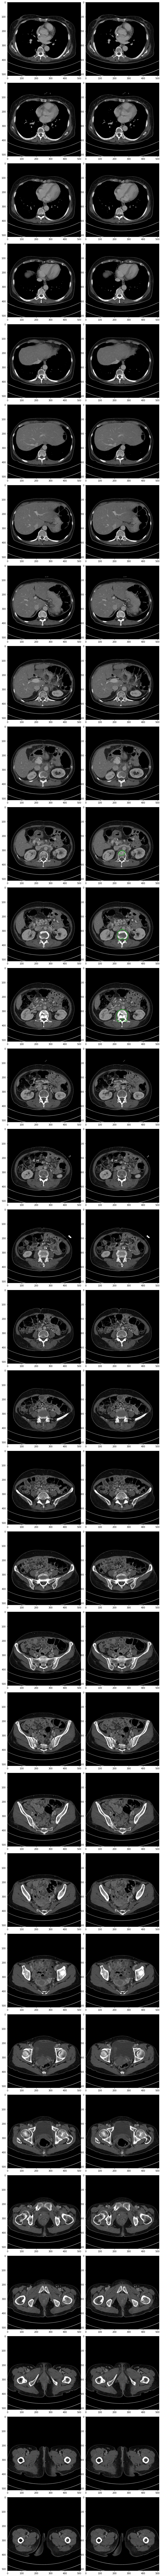

In [15]:
file_test(IMG_FILES[370])
# for file in IMG_FILES:
#     file_test_save(file)